# Initialization

In [1]:
!pip install numpy qiskit torch matplotlib tqdm torchvision cirq

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.2 MB/s eta 0:00:006.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.7 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 8.4 MB/s eta 0:00:009.1 MB/s eta 0:00:01m


In [24]:
import numpy as np
import cirq
import random

SINGLE_QUBIT_GATES = ["X", "Y", "Z", "H", "T", "S", "rx", "ry", "rz"]
TWO_QUBIT_GATES = ["cx", "cz", "swap"]

# Quantum circuit simulations

In [27]:
def random_circuit(n_qubits: int, depth: float) -> tuple[cirq.Circuit, list[cirq.LineQubit]]:
    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()
    for _ in range(depth):
        if random.random() < 0.7:
            q = random.choice(qubits)
            g = random.choice(SINGLE_QUBIT_GATES)
            if g in ["rx", "ry", "rz"]:
                theta = 2*np.pi*random.random()
                circuit.append(getattr(cirq, g)(theta)(q))
            else: 
                circuit.append(getattr(cirq, g)(q))
        else:
            q1, q2 = random.sample(qubits, 2)
            g = random.choice(TWO_QUBIT_GATES)
            if g == "cx":
                circuit.append(cirq.CNOT(q1, q2))
            elif g == "cz":
                circuit.append(cirq.CZ(q1, q2))
            elif g == "swap":
                circuit.append(cirq.SWAP(q1, q2))
    return circuit, qubits

In [17]:
def add_noise(circuit: cirq.Circuit, qubits: cirq.LineQubit, noise_type: str, p: float) -> cirq.Circuit:
    noisy = cirq.Circuit()
    kinds = ["bitflip", "depolarizing", "amp_damp", "phase_damp"]

    for moment in circuit:
        noisy += moment
        if noise_type == "mixed":
            kind = random.choice(kinds)
        else:
            kind = noise_type

        if kind == "bitflip":
            noisy += cirq.bit_flip(p).on_each(*qubits)
        elif kind == "depolarizing":
            noisy += cirq.depolarize(p).on_each(*qubits)
        elif kind == "amp_damp":
            noisy += cirq.amplitude_damp(p).on_each(*qubits)
        elif kind == "phase_damp":
            noisy += cirq.phase_damp(p).on_each(*qubits)

    return noisy

In [18]:
def simulate_density_matrix(circuit):
    simulator = cirq.DensityMatrixSimulator()
    result = simulator.simulate(circuit)
    return result.final_density_matrix

In [20]:
def generate_dataset(n_samples=1000, n_qubits=3, noise_level=0.05):
    X, Y = [], []
    for _ in range(n_samples):
        circuit, qubits = random_circuit(n_qubits, depth=8)
        rho_clean = simulate_density_matrix(circuit)
        noisy_circuit = add_noise(circuit, qubits, "mixed", noise_level)
        rho_noisy = simulate_density_matrix(noisy_circuit)

        X.append(np.stack([rho_noisy.real, rho_noisy.imag], axis=-1))
        Y.append(np.stack([rho_clean.real, rho_clean.imag], axis=-1))
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


# Transformer architecture

Papers to reference

@misc{kendre2025machinelearningquantumnoise,
      title={Machine Learning for Quantum Noise Reduction}, 
      author={Karan Kendre},
      year={2025},
      eprint={2509.16242},
      archivePrefix={arXiv},
      primaryClass={quant-ph},
      url={https://arxiv.org/abs/2509.16242},
      file="./2509.16242v1.pdf",
}

@misc{norambuena2023physicsinformedneuralnetworksquantum,
      title={Physics-informed neural networks for quantum control}, 
      author={Ariel Norambuena and Marios Mattheakis and Francisco J. González and Raúl Coto},
      year={2023},
      eprint={2206.06287},
      archivePrefix={arXiv},
      primaryClass={quant-ph},
      url={https://arxiv.org/abs/2206.06287},
      file="./2206.06287v2.pdf",
}

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class QuantumDenoisingDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx].permute(2, 0, 1), self.Y[idx].permute(2, 0, 1)
        

In [ ]:
# class PatchEmbed
# Going to sleep now

# Testing

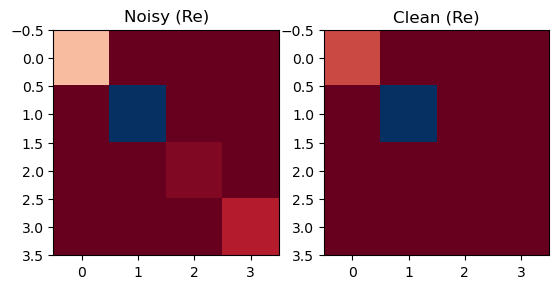

In [31]:
import matplotlib.pyplot as plt

X, Y = generate_dataset(n_samples=1, n_qubits=2)
plt.subplot(1,2,1)
plt.imshow(X[0,:,:,0], cmap='RdBu'); plt.title("Noisy (Re)")
plt.subplot(1,2,2)
plt.imshow(Y[0,:,:,0], cmap='RdBu'); plt.title("Clean (Re)")
plt.show()
